In [ ]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras

sys.path.append( '../..' )
from utils import LP_PSDs

In [ ]:
tf.config.list_physical_devices()
%load_ext tensorboard

# Sacamos los datos

In [ ]:
x_train, x_test = LP_PSDs(test_size=0.3)
fq_size = x_train.shape[1]
X_test = x_test.reshape(x_test.shape[0], fq_size, 1)
X_train =x_train.reshape(x_train.shape[0], fq_size, 1)

# Entrenamos los modelos

### Simple AutoEncoder

In [ ]:
keras.backend.clear_session()
input_img = keras.layers.Input(shape=(fq_size,))
encoded = keras.layers.Dense(18, activation='relu')(input_img)
decoded = keras.layers.Dense(fq_size, activation='sigmoid')(encoded)
AE = keras.models.Model(input_img, decoded)
keras.utils.plot_model(AE, show_shapes=True)

In [ ]:
AE.compile(optimizer='adam', loss='binary_crossentropy')

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

%tensorboard --logdir logs

In [ ]:
history = AE.fit(x_train, x_train,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[tensorboard_callback]
                )

In [ ]:
x_pred = AE.predict(x_test)
plt.figure(figsize=(20, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    n = np.random.randint(0, x_test.shape[0])
    ax.plot(x_test[n,:], color='k')
    ax.plot(x_pred[n,:], color='r')

In [ ]:
encoder = keras.models.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(encoder.predict(x_train))
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], s=10)

### RNN AutoEncoder

In [ ]:
keras.backend.clear_session()
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(36, return_sequences=True, activation='relu', input_shape=[fq_size, 1]),
    keras.layers.LSTM(18, activation='relu')
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(fq_size, input_shape=[18]),
    keras.layers.LSTM(36, activation='relu', return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1, activation="sigmoid"))
])
rnn_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
keras.utils.plot_model(rnn_ae, show_shapes=True)

In [ ]:
rnn_ae.compile(optimizer='adam', loss='binary_crossentropy')

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

%tensorboard --logdir logs

In [ ]:
history = rnn_ae.fit(X_train, X_train,
                epochs=200,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[tensorboard_callback]
                )

In [ ]:
x_pred = rnn_ae.predict(X_test)
plt.figure(figsize=(20, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    n = np.random.randint(0, x_test.shape[0])
    ax.plot(x_test[n,:,0], color='k')
    ax.plot(x_pred[n,:,0], color='r')

In [ ]:
encoded_imgs = recurrent_encoder.predict(X_train)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(recurrent_encoder.predict(X_train))
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], s=10)

### Deep AutoEncoder

In [ ]:
keras.backend.clear_session()
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(fq_size,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(36, activation="selu"),
    keras.layers.Dense(18, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(36, activation="selu", input_shape=[18]),
    keras.layers.Dense(fq_size, activation="sigmoid")
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
keras.utils.plot_model(dropout_ae, show_shapes=True)
dropout_ae.summary()

In [ ]:
dropout_ae.compile(loss="binary_crossentropy", optimizer='adam')
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

%tensorboard --logdir logs
history = dropout_ae.fit(x_train, x_train, epochs=100,
                         validation_data=(x_test, x_test))

In [ ]:
x_pred = dropout_ae.predict(x_test)
plt.figure(figsize=(20, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    n = np.random.randint(0, x_test.shape[0])
    ax.plot(x_test[n,:], color='k')
    ax.plot(x_pred[n,:]/x_pred[n,:].max(), color='r')

In [ ]:
tsne = TSNE()
X_valid_2D = tsne.fit_transform(dropout_encoder.predict(x_train))
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], s=10)

### Sparse Autoencoder

In [ ]:
keras.backend.clear_session()
sparse_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[fq_size,]),
    keras.layers.Dense(25, activation="selu"),
    keras.layers.Dense(50, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternativamente, se puede utilizar activity_regularizer=keras.regularizers.l1(1e-3) en la capa previa
])
sparse_decoder = keras.models.Sequential([
    keras.layers.Dense(25, activation="selu", input_shape=[50]),
    keras.layers.Dense(fq_size, activation="sigmoid")
])
sparse_ae = keras.models.Sequential([sparse_encoder, sparse_decoder], name='Sparse')
keras.utils.plot_model(sparse_ae, show_shapes=True)
sparse_ae.summary()

In [ ]:
sparse_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=['accuracy'])
history = sparse_ae.fit(x_train, x_train, epochs=200,
                           validation_data=(x_test, x_test))

In [ ]:
x_pred = sparse_ae.predict(x_test)
plt.figure(figsize=(20, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    n = np.random.randint(0, x_test.shape[0])
    ax.plot(x_test[n,:], color='k')
    ax.plot(x_pred[n,:]/x_pred[n,:].max(), color='r')

In [ ]:
tsne = TSNE()
X_valid_2D = tsne.fit_transform(sparse_encoder.predict(x_train))
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], s=10)

### Convolutional AutoEncoder

In [ ]:
keras.backend.clear_session()
conv_encoder = keras.models.Sequential([
    keras.layers.Conv1D(filters=25, kernel_size=4, activation="selu", input_shape=[fq_size,1], padding="same"),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(filters=12, kernel_size=1, activation='selu', padding='same'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(filters=5, kernel_size=3, activation='selu', padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(25, activation='selu'),
    keras.layers.Reshape([25,1])
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv1D(5, kernel_size=4, activation='selu', input_shape=[25, 1], padding='same'),
    keras.layers.UpSampling1D(2),
    keras.layers.Conv1D(12, kernel_size=4, activation='selu', padding='same'),
    keras.layers.UpSampling1D(2),
    keras.layers.Conv1D(25, kernel_size=4, activation='selu', padding='same'),
    keras.layers.Conv1D(1, kernel_size=4, activation='sigmoid')
])

# keras.utils.plot_model(conv_encoder, show_shapes=True)
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
keras.utils.plot_model(conv_ae, show_shapes=True)
conv_ae.summary()

In [ ]:
conv_ae.compile(optimizer='adam', loss='binary_crossentropy')
history = conv_ae.fit(X_train, X_train,
            epochs=100,
            batch_size=32,
            shuffle=True,
            validation_data=(X_test, X_test))

In [ ]:
x_pred = conv_ae.predict(X_test)
plt.figure(figsize=(20, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    n = np.random.randint(0, X_test.shape[0])
    ax.plot(x_test[n,:,0], color='k')
    ax.plot(x_pred[n,:,0], color='r')

In [ ]:
encoded_imgs = conv_encoder.predict(X_train)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(encoded_imgs.reshape(encoded_imgs.shape[0],encoded_imgs.shape[1]))
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], s=10)

### Variational AutoEncoder

In [ ]:
keras.backend.clear_session()

K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [ ]:
# encoder
inputs = keras.layers.Input(shape=(fq_size,), name='encoder_input')
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(50, activation='relu')(x)
z_mean = keras.layers.Dense(18, name='z_mean')(x)
z_logvar = keras.layers.Dense(18, name='z_var')(x)
z = Sampling()([z_mean, z_logvar])
variational_encoder = keras.models.Model(inputs = [inputs], 
                                         outputs=[z_mean, z_logvar, z],
                                         name='variational_encoder')
variational_encoder.summary()
keras.utils.plot_model(variational_encoder, show_shapes=True)

In [ ]:
# decoder
latent_inputs = keras.layers.Input(shape=(18,))
x = keras.layers.Dense(50, activation='relu')(latent_inputs)
# Uso una función sigmoide para la activación de la última capa para asegurarme de tener pixeles en [0,1]
x = keras.layers.Dense(fq_size, activation='sigmoid')(x)
outputs = keras.layers.Reshape([fq_size,])(x)

# instanceo el modelo del decoder
variational_decoder = keras.models.Model(inputs=[latent_inputs], outputs=[outputs], name='variational_decoder')
variational_decoder.summary()
keras.utils.plot_model(variational_decoder, show_shapes=True)

In [ ]:
#el decoder es el modelo
#z es la variable definida como el tercer output del encoder
outputs = variational_decoder(z)

#autoencoder:
vae = keras.models.Model(inputs, outputs, name='vae_mlp')
keras.utils.plot_model(vae, show_shapes=True)

In [ ]:
latent_loss = -0.5 * K.sum(
    1 + z_logvar - K.exp(z_logvar) - K.square(z_mean),
    axis=-1)

vae.add_loss(K.mean(latent_loss) / fq_size ) #agregamos la función de perdida latente
vae.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

hist = vae.fit(x_train, x_train,
        shuffle=True,
        epochs=200,
        batch_size=32,
        validation_data=(x_test, x_test),
        callbacks = [early_stopping_cb, tensorboard_callback])

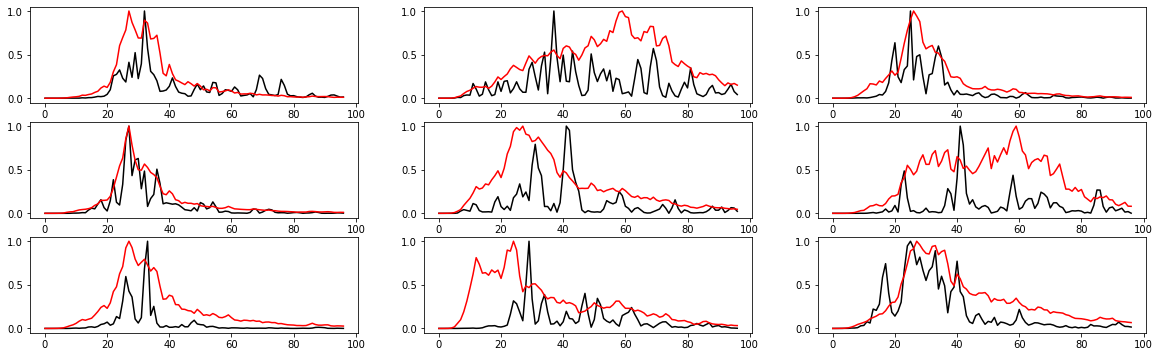

In [34]:
x_pred = vae.predict(x_test)
plt.figure(figsize=(20, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    n = np.random.randint(0, x_test.shape[0])
    ax.plot(x_test[n,:], color='k')
    ax.plot(x_pred[n,:]/x_pred[n,:].max(), color='r')

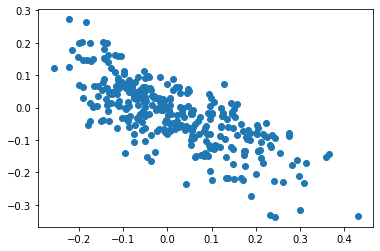

In [35]:
z_mean, z_var, z = variational_encoder.predict(x_test, batch_size=32)
plt.scatter(z_mean[:, 0], z_mean[:, 1])